In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dear colleagues of mine that will be taking upon my hard work,

thank you so much for this compelling data set. I see that you are interested in:
- measuring mutability as defined in the [paper](http://arxiv.org/pdf/1407.0145.pdf): which is basically a measure of how the community structure of a (mobility) network changes over time.
- being able to measure that mutability in different aggregations of time (weekly mobility nets, daily,…) and space (nodes as lat/long points or as cells of some fixed size).
- generate some compelling visuals of the study (maps or/and plots)

The given dataset is not quite a mobility network but it can be made into one in various ways. The most reasonable way seems to be to take succeeding checkins as journeys. That is probably problematic for succeeding checkins that have a big time difference but we can filter those out if we want.

Since all data projects are 80% data wrangling (and that is also the least fun) of course that is where I start (to free you from that sort of boring work).

Now this is what I have done so far:

## Preparations

First of all I converted TSV files to CSV files

    cat loc-gowalla_totalCheckins.txt | tr "\\t" "," > checkins.csv

The dataset is huge but I'm assuming we're interested in movement inside of urban areas, thus we want to filter down to lat/lon-bounding boxes like -74.2590899,40.477399,-73.7001714,40.917577 for NYC.

I've made a simple command-line tool for this: `filter_bb.rb` and it's used like this:

    ruby filter_bb.rb -74.2590899,40.477399,-73.7001714,40.917577 checkins.csv > checkins_nyc.csv

In [208]:
checkins = pd.read_csv('checkins_nyc.csv', names=['user_id', 'ts', 'lat', 'lon', 'venue_id'], parse_dates=['ts'])
checkins.head(10)

,user_id,ts,lat,lon,venue_id
0,0,2010-10-12 00:21:28,40.643885,-73.782806,23261
1,0,2010-10-11 20:21:20,40.741374,-73.988105,16907
2,0,2010-10-11 20:20:42,40.741388,-73.989455,12973
3,0,2010-10-11 00:06:30,40.724910,-73.994621,341255
4,0,2010-10-10 22:00:37,40.729768,-73.998535,260957
5,0,2010-10-10 21:17:14,40.728527,-73.996868,1933724
6,0,2010-10-10 17:47:04,40.741747,-73.993421,105068
7,0,2010-10-09 23:51:10,40.734193,-74.004164,34817
8,0,2010-10-09 22:27:07,40.742512,-74.006031,27836
9,0,2010-10-09 21:39:26,40.742396,-74.007543,15079


## Venues

The venues (or bins of venues) will be the nodes in our graph. I created a `venues` DataFrame from the `checkins` here. I also wanted to have a look at NYs checkins on a map to verify that I made no mistakes.

In [204]:
venues = checkins.groupby('venue_id').first()
venues['total_checkins'] = checkins.groupby('venue_id').count()['user_id']

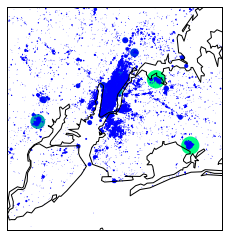

In [205]:
from mpl_toolkits.basemap import Basemap
m = Basemap(projection='merc',llcrnrlat=40.477399,urcrnrlat=40.917577,\
            llcrnrlon=-74.2590899,urcrnrlon=-73.7001714,resolution='h')
m.drawcoastlines()
m.scatter(venues['lon'].values, venues['lat'].values, s=venues['total_checkins']/5, c=venues['total_checkins'], cmap=plt.cm.get_cmap('winter'), edgecolors='none', latlon=True)

That looks pretty reasonable. Note the how easily the airports can be spotted. Also the center of Central Park has a big marker. Popular spot. But most of the venues have a rather small number of checkins.

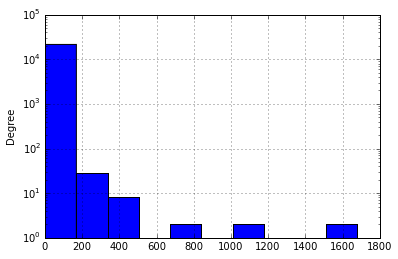

In [202]:
venues.total_checkins.plot(kind='hist', logy=True)

## Building the journeys

Next I created a the `journeys` data frame - from this you can later build aggregations of journeys through space and time.

In [147]:
journeys = []
for venue_id, group in checkins.groupby('user_id'):
    group = group.sort('ts')
    for i in xrange(len(group)-1):
        journey = dict(user_id=group.iloc[i].user_id,
                       start_ts=group.iloc[i].ts,
                       end_ts=group.iloc[i+1].ts,
                       ts_diff=group.iloc[i+1].ts-group.iloc[i].ts,
                       start_venue_id=group.iloc[i].venue_id,
                       end_venue_id=group.iloc[i+1].venue_id,
                       start_lat=group.iloc[i].lat,
                       end_lat=group.iloc[i+1].lat,
                       start_lon=group.iloc[i].lon,
                       end_lon=group.iloc[i+1].lon)
        journeys.append(journey)

journeys = pd.DataFrame(journeys)

In [207]:
journeys.head(10)

,end_lat,end_lon,end_ts,end_venue_id,start_lat,start_lon,start_ts,start_venue_id,ts_diff,user_id
0,40.751508,-73.975500,2010-10-07 20:14:44,34484,40.643885,-73.782806,2010-10-07 15:27:40,23261,04:47:04,0
1,40.748444,-73.985732,2010-10-07 20:31:48,12313,40.751508,-73.975500,2010-10-07 20:14:44,34484,00:17:04,0
2,40.745810,-73.988221,2010-10-07 21:02:01,60450,40.748444,-73.985732,2010-10-07 20:31:48,12313,00:30:13,0
3,40.742201,-73.987995,2010-10-07 21:58:31,17710,40.745810,-73.988221,2010-10-07 21:02:01,60450,00:56:30,0
4,40.730869,-73.997566,2010-10-07 23:18:10,16397,40.742201,-73.987995,2010-10-07 21:58:31,17710,01:19:39,0
5,40.731724,-74.003338,2010-10-08 00:07:48,87914,40.730869,-73.997566,2010-10-07 23:18:10,16397,00:49:38,0
6,40.780805,-73.976473,2010-10-08 17:24:27,35513,40.731724,-74.003338,2010-10-08 00:07:48,87914,17:16:39,0
7,40.769378,-73.963083,2010-10-08 19:28:36,1567837,40.780805,-73.976473,2010-10-08 17:24:27,35513,02:04:09,0
8,40.705823,-73.996696,2010-10-08 21:43:02,11794,40.769378,-73.963083,2010-10-08 19:28:36,1567837,02:14:26,0
9,40.707071,-74.011953,2010-10-08 21:43:52,15169,40.705823,-73.996696,2010-10-08 21:43:02,11794,00:00:50,0


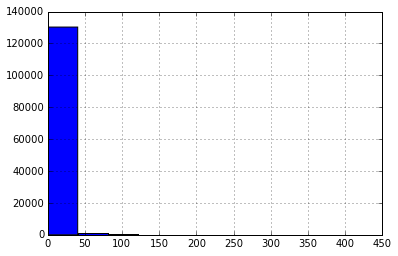

In [179]:
journeys_lt8h.ts_diff.describe()
journeys.ts_diff.astype('timedelta64[D]').hist()

There actually were a few checkins where a lot of time passed between them. For that reason I looked at "journeys shorter than 8h" because those are more likely to resemble an actual journey in the sense of: The person traveled from here to there. 8h is of course arbitrary. There might be better choices.

count                     81896
mean     0 days 01:12:12.619285
std      0 days 01:49:03.332010
min             0 days 00:00:00
25%             0 days 00:00:28
50%             0 days 00:14:01
75%      0 days 01:44:04.250000
max             0 days 07:59:48
Name: ts_diff, dtype: object

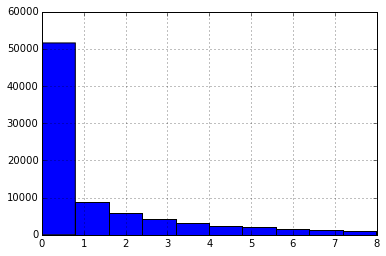

In [180]:
journeys_lt8h = journeys[journeys.ts_diff < np.timedelta64(8, 'h')]
(journeys_lt8h.ts_diff.astype('timedelta64[m]')/60).hist()
journeys_lt8h.ts_diff.describe()

In [206]:
print len(journeys_lt8h)
print len(venues)

81896
21509


For New York City a get 21509 Venues and 81896 journeys between them.

## Graph analysis

I have actually done this preliminary work in Python because in the research phase `python-igraph` looked highly useful and I also found a [louvain method](https://github.com/vtraag/louvain-igraph) implementation for it.

The [`subgraph`](https://pythonhosted.org/python-igraph/igraph.clustering.VertexClustering-class.html#subgraph) function of [`VertexClustering`](https://pythonhosted.org/python-igraph/igraph.clustering.VertexClustering-class.html) is very much the $C_i(t)$ function in $γ_i(t_1,t_2)$.

I was hoping to be able to provide you with at least one example of plotting the clustering of venues on a map. Unfortunately my time ran out trying to get the (unaggregated) graph into `igraph` but here is how you would go on:

1. Get venues as vertices and journeys as edges into igraph
2. run the clustering
3. print the same map as above but with colors according to cluster membership

This is where I wanted to be. The your next steps would be the following:

4. Aggregations into space bins can then be done with [`pandas.cut`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html) on lat/lon and then grouping by the new categorial columns. That can be done on the `venues` as well as on the `journeys`
5. For aggregations into time bins a similar technique should work. There still has to be some thought spent onto what goes into the $t$-bin – Sun et al. have made time windows $[t-\Delta t, t+\Delta t)$ and selected journeys $⊂$ this time window but their journeys have accurate start end end times - ours are manufactured.
6. Build a function `mutability(t_min, t_max, delta_t, delta_lat, delta_lon, venues, journeys)` that pulls everything together and returns an array of lat/lon-bounding boxes with their associated mutability score - putting this on a map is a piece of cake.

### Some more general remarks

Some of the steps already took quite a long time on my Macbook. If this is a one-off analysis then this is fine. If this were to become a tool that informs decision makers who need current data and quick answers when the backend shouldn't be python. There seem to be some mature graph analysis libraries for GraphX (spark) and Giraph e.g. https://github.com/Sotera/distributed-graph-analytics

I still don't think that even with parallel processing any of this could be real time (especially because the modularity $Q$ has to be optimized for each $t$ separately which is costly for small $\Delta t$. According to http://arxiv.org/pdf/0803.0476v2.pdf using the louvain method we'll still need ~0.4s _per optimization_. That would make on demand calculation in a real time viz impractical (that still has to be tested).

Different topic: It took me quite some time to actually get into the topic. The last time I have done graph analysis was more than 6 years ago at university (in a seminar about random graphs). I even think I have cheated in this assessment by not counting the time I spent to inform myself on the topic on a broader scale. Anyway - thanks for the opportunity to learn something new.

Also a word of critique: This is clearly a toy task. Depending on how many candidates you assessed you burned x hours of time – that's probably more than it would have cost you to find a real problem that you currently face to give it to the candidates. At least you gave a clear time box to limit waste. 

## What I could not finish

As said I wanted to ingest the data into igraph next but I couldn't finish it...

In [152]:
import louvain
import igraph as ig

In [189]:
G = ig.Graph()

In [190]:
G.add_vertices(len(venues))

In [191]:
for i in xrange(len(journeys)):
    journey = journeys_lt8h.iloc[i]
    # add an edge between the start venue and the end venue
    G.add_edge(venues.index.get_loc(journey.start_venue_id), venues.index.get_loc(journey.end_venue_id))

IndexError: index 81896 is out of bounds for axis 0 with size 81896

## Me plaiying around with igraph

In [2]:
G = ig.Graph.Erdos_Renyi(100, 0.1);

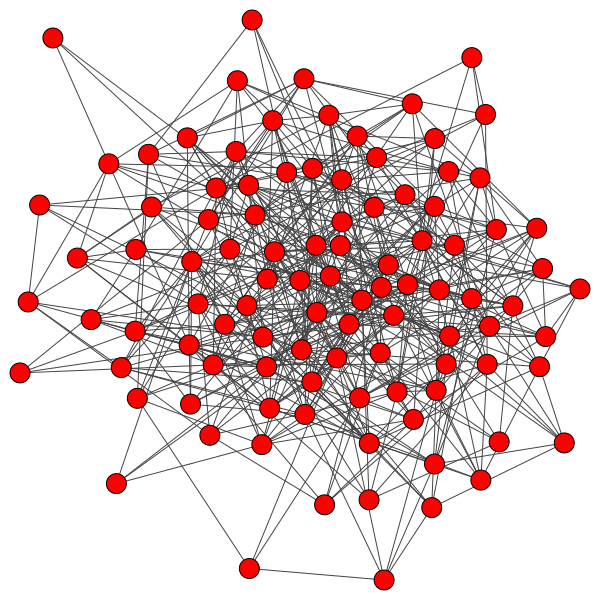

In [23]:
ig.plot(G, layout = G.layout('fr'))

In [4]:
part = louvain.find_partition(G, method='Modularity')

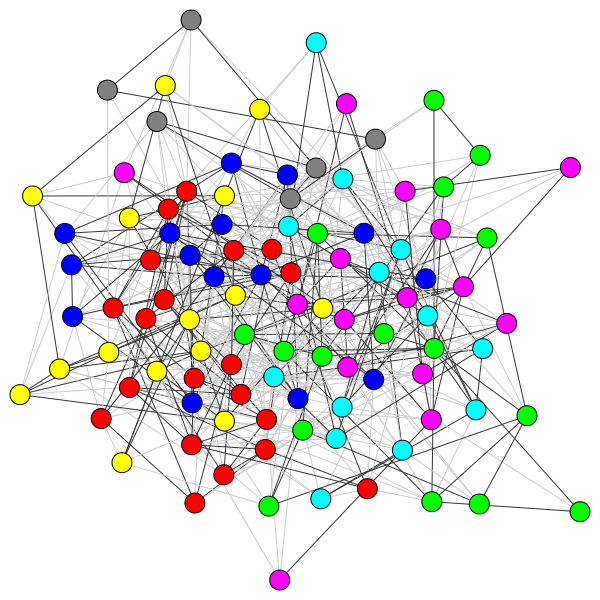

In [24]:
ig.plot(part, layout = G.layout('fr'))

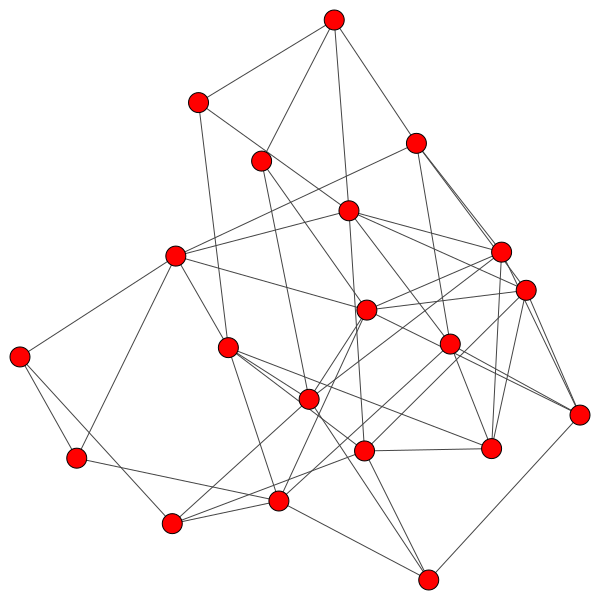

In [9]:
ig.plot(part.subgraph(0))

In [15]:
part.membership

[5,
 2,
 0,
 1,
 0,
 5,
 5,
 0,
 3,
 5,
 0,
 0,
 4,
 0,
 1,
 3,
 0,
 1,
 6,
 2,
 4,
 4,
 5,
 4,
 5,
 2,
 0,
 4,
 6,
 6,
 2,
 3,
 5,
 3,
 3,
 5,
 3,
 4,
 2,
 1,
 1,
 4,
 2,
 4,
 1,
 2,
 1,
 0,
 3,
 0,
 4,
 1,
 2,
 2,
 3,
 0,
 5,
 3,
 0,
 0,
 2,
 6,
 4,
 1,
 1,
 6,
 3,
 3,
 3,
 5,
 0,
 0,
 2,
 0,
 6,
 4,
 1,
 0,
 4,
 1,
 1,
 4,
 5,
 1,
 1,
 4,
 2,
 2,
 1,
 5,
 5,
 2,
 3,
 4,
 0,
 2,
 3,
 3,
 0,
 0]

In [18]:
part.subgraph(0).vs